# CIE Project A - Group 7
## ---> Data processing

### Imports

In [135]:
import os

import pandas as pd
import numpy as np
from scipy import signal as sp
from sklearn import preprocessing ##importing for normalization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.frameon'] = True
%matplotlib widget

# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix

#### Get the root directory and change to it

In [136]:
rootdir = os.getcwd()
os.chdir(rootdir)

### Variable Assignment

In [137]:
gyrFile = 'Gyroscope'
accFile = 'Accelerometer'

normal = 'Normal'
upstairs = 'Upstairs'
downstairs = 'Downstairs'

smartphone =  [3]

s1 = 'Smartphone1'
s3 = 'Smartphone3'

s = [s3]

gaitpos = [normal, upstairs, downstairs]

### Data Parsing

#### Define variables for raw data

In [138]:
count = 0

# Naming convention - gyr(oscope)_s(martphone_location)) and Same for acceleraoemeter
# All the data is stored in a list of dataframes. So, gyr{gaitpos}_s{martphone_location}[0, 1, 2, .....] gives the data as sorted by name in the file directory.
# gyrNormal_s1[0] gives the gyroscope data of the subject180_Normal sample 01 in the normal gait position.
# gyrNormal_s1[1] gives the gyroscope data of the subject180_Normal sample 02 in the normal gait position.
# 
# gyrNormal_s[2] gives the gyroscope data of the subject181_Normal sample 01 in the normal gait position.
# 
# and so on. 

# defining arrays for gyroscope data
gyrNormal_s1 = []; gyrUpstairs_s1 = []; gyrDownstairs_s1 = []
gyrNormal_s3 = []; gyrUpstairs_s3 = []; gyrDownstairs_s3 = []

#defining arrays for accelerometer data
accNormal_s1 = []; accUpstairs_s1 = []; accDownstairs_s1 = []
accNormal_s3 = []; accUpstairs_s3 = []; accDownstairs_s3 = []

#### Parsing gyroscope and accelerometer data at all gait positions (Smartphone 1 - Rear Right) & (Smartphone 3 - Front Right)

In [139]:
for subdir, dirs, files in os.walk(rootdir):
    for foldername in s:
        for gait in gaitpos:    
        
            gyr = eval(f'gyr{gait}_s{foldername[10]}')
            acc = eval(f'acc{gait}_s{foldername[10]}')
            
            if foldername.lower() in subdir.lower():
                if gait.lower() in subdir.lower():
    
                    for file in files:

                        if gyrFile.lower() in file.lower():
                            count = count + 1
                            # print(f'#{count} -- {os.path.join(subdir, file)}')

                            with open(os.path.join(subdir, file), 'r') as f: # open in read-only mode
                                gyrData = pd.read_csv(f)
                                # Assemble the data into a tensor
                                gyr.append(gyrData)

                        if accFile in file:
                            count = count + 1
                            # print(f'#{count} -- {os.path.join(subdir, file)}')

                            with open(os.path.join(subdir, file), 'r') as f: # open in read-only mode
                                accData = pd.read_csv(f)
                                # Assemble the data into a tensor
                                acc.append(accData)

#### Check if the data is collected correctly after parsing

In [140]:
# getting the data shape for reference
for j in gaitpos:
    for i in smartphone:
            gyrl = eval(f'gyr{j}_s{i}')
            accl = eval(f'acc{j}_s{i}')

            print(f'Shape of gyr{j}_s{i} is ------ {np.asarray((gyrl), dtype = list).shape}')
            print(f'Shape of acc{j}_s{i} is ------ {np.asarray((accl), dtype = list).shape} \n')

Shape of gyrNormal_s3 is ------ (8,)
Shape of accNormal_s3 is ------ (8,) 

Shape of gyrUpstairs_s3 is ------ (8,)
Shape of accUpstairs_s3 is ------ (8,) 

Shape of gyrDownstairs_s3 is ------ (7,)
Shape of accDownstairs_s3 is ------ (7,) 



### Data Validation and Preprocessing

##### -- No need to run -- Frequency check of all the data before filtering

In [141]:
freqGyr = []
freqAcc = []

# Loop through the variables and check if all the data is collected
for j in gaitpos:
    for i in smartphone:
        # Calculating gyroscope frequency before preprocessing
        gyrl = eval(f'gyr{j}_s{i}')
        ng = len(gyrl)

        # loop to calculate the frequency over all the data
        for s in range(0, ng):
            time = np.asarray(gyrl[s].iloc[:,0])

            freqG = np.round(len(time)/(time[-1]))
            freqGyr.append(freqG)
        
        # Calculating accelerometer frequency before preprocessing
        accl = eval(f'acc{j}_s{i}')
        na = len(accl)

        # loop to calculate the frequency over all the data
        for s in range(0, na):
            time = np.asarray(accl[s].iloc[:,0])

            freqA = np.round(len(time)/(time[-1]))
            freqAcc.append(freqA)

for i in range(0, len(freqGyr)):
    if freqGyr[i] < 10:
        print(f'Position of the frequency issue is at freqGyr:{i} and the frequency is {freqGyr[i]}')
for j in range(0, len(freqAcc)):
    if freqAcc[j] < 10:
        print(f'Position of the frequency issue is at freqAcc:{j} and the frequency is {freqAcc[j]}')

### Filter Data

#### Lowpass filter (Butterworth) function

In [142]:
#Filter the data to remove noise

# inputs for the function is the data, the sampling frequency, the cutoff frequency.
def dataFilter(dataInput, fs=200, fc=5, order = 2):
    Filtrd = np.zeros(dataInput.shape)
    w = fc / (fs * 0.5)
    b, a = sp.butter(fc, w, 'low')
    
    #Filter the X, Y and Z axis of the input data
    for i in range(0, 3):
        Filtrd[:,i] = sp.filtfilt(b, a, dataInput.iloc[:,i+1])

    return Filtrd

##### -- Different filter check -- Chebyshev filter

In [143]:
'''
# chebyshev filter for the accelerometer data
def chebyFilter(dataInput, fs=200, fc=5, order = 2):
    Filtrd = np.zeros(dataInput.shape)
    w = fc / (fs * 0.5)
    b, a = sp.cheby2(order, 20, w, 'low')
    
    #Filter the X, Y and Z axis of the input data
    for i in range(0, 3):
        Filtrd[:,i] = sp.filtfilt(b,a, dataInput.iloc[:,i+1])
    
    return Filtrd
'''

"\n# chebyshev filter for the accelerometer data\ndef chebyFilter(dataInput, fs=200, fc=5, order = 2):\n    Filtrd = np.zeros(dataInput.shape)\n    w = fc / (fs * 0.5)\n    b, a = sp.cheby2(order, 20, w, 'low')\n    \n    #Filter the X, Y and Z axis of the input data\n    for i in range(0, 3):\n        Filtrd[:,i] = sp.filtfilt(b,a, dataInput.iloc[:,i+1])\n    \n    return Filtrd\n"

#### -- Test -- the dataFilter function and its dependency on the frequency input

In [144]:
'''gyrF = []
accF = []
ng = len(gyrNormal_s1)
na = len(accNormal_s1)

for i in range(0, ng):
    timeg = np.asarray(gyrNormal_s1[i].iloc[:,0])
    freqG = np.round(len(timeg)/(timeg[-1]))
    gyrF.append(freqG)

for j in range(0, na):
    timea = np.asarray(accNormal_s1[j].iloc[:,0])
    freqA = np.round(len(timea)/(timea[-1]))
    accF.append(freqA)

gyrFilt = []
accFilt = []

for rg in range(0, ng):
    gf = dataFilter(gyrNormal_s1[rg], fs = 100)
    gyrFilt.append(gf)

for ra in range(0, na):
    af = dataFilter(accNormal_s1[ra], fs = 100)
    accFilt.append(af)

t1 = np.asarray(gyrNormal_s1[0].iloc[:,0])
f1 = np.round(len(t1)/(t1[-1]))

xyz = dataFilter(gyrNormal_s1[0], fs = f1)

plt.close('all')
plt.plot(gyrNormal_s1[0].iloc[:,1], 'r')
plt.plot(xyz[:,0], 'b')
plt.show()'''

"gyrF = []\naccF = []\nng = len(gyrNormal_s1)\nna = len(accNormal_s1)\n\nfor i in range(0, ng):\n    timeg = np.asarray(gyrNormal_s1[i].iloc[:,0])\n    freqG = np.round(len(timeg)/(timeg[-1]))\n    gyrF.append(freqG)\n\nfor j in range(0, na):\n    timea = np.asarray(accNormal_s1[j].iloc[:,0])\n    freqA = np.round(len(timea)/(timea[-1]))\n    accF.append(freqA)\n\ngyrFilt = []\naccFilt = []\n\nfor rg in range(0, ng):\n    gf = dataFilter(gyrNormal_s1[rg], fs = 100)\n    gyrFilt.append(gf)\n\nfor ra in range(0, na):\n    af = dataFilter(accNormal_s1[ra], fs = 100)\n    accFilt.append(af)\n\nt1 = np.asarray(gyrNormal_s1[0].iloc[:,0])\nf1 = np.round(len(t1)/(t1[-1]))\n\nxyz = dataFilter(gyrNormal_s1[0], fs = f1)\n\nplt.close('all')\nplt.plot(gyrNormal_s1[0].iloc[:,1], 'r')\nplt.plot(xyz[:,0], 'b')\nplt.show()"

#### Filtering all the data

In [145]:
# defining arrays for filtered gyroscope data
#gyrFilteredNormal_s1 = []; gyrFilteredUpstairs_s1 = []; gyrFilteredDownstairs_s1 = []
gyrFilteredDownstairs_s3 = []; gyrFilteredUpstairs_s3 = []; gyrFilteredNormal_s3 = []

# defining arrays for filtered accelerometer data
#accFilteredNormal_s1 = []; accFilteredUpstairs_s1 = []; accFilteredDownstairs_s1 = []
accFilteredNormal_s3 = []; accFilteredUpstairs_s3 = []; accFilteredDownstairs_s3 = []

for j in gaitpos:
    for i in smartphone:
            # variables of raw the data
            gyrl = eval(f'gyr{j}_s{i}')
            accl = eval(f'acc{j}_s{i}')
            
            # variables of filtered the data
            gyrF = eval(f'gyrFiltered{j}_s{i}')
            accF = eval(f'accFiltered{j}_s{i}')

            # getting the shape of the gyroscope data (first integer)
            ng = len(gyrl)

            # Getting the shape of the accelerometer data (first integer)
            na = len(accl)


            # Filter all the data
            for rg in range(0, ng):
                timeg = np.asarray(gyrl[rg].iloc[:,0])
                fG = np.round(len(timeg)/(timeg[-1]))

                gf = dataFilter(gyrl[rg], fs = fG)
                gyrF.append(gf)

            for ra in range(0, na):
                timea = np.asarray(accl[ra].iloc[:,0])
                fA = np.round(len(timea)/(timea[-1]))

                af = dataFilter(accl[ra], fs = fA)
                accF.append(af)
print(type(gyrFilteredDownstairs_s3))

<class 'list'>


#### Check if all the data is collected correctly after filtering

In [146]:
# getting the data shape for reference
for j in gaitpos:
    for i in smartphone:
            gyrl = eval(f'gyrFiltered{j}_s{i}')
            accl = eval(f'accFiltered{j}_s{i}')

            print(f'Shape of gyrFiltered{j}_s{i} is ------ {np.asarray((gyrl), dtype = list).shape}')
            print(f'Shape of accFiltered{j}_s{i} is ------ {np.asarray((accl), dtype = list).shape} \n')

Shape of gyrFilteredNormal_s3 is ------ (8,)
Shape of accFilteredNormal_s3 is ------ (8,) 

Shape of gyrFilteredUpstairs_s3 is ------ (8,)
Shape of accFilteredUpstairs_s3 is ------ (8,) 

Shape of gyrFilteredDownstairs_s3 is ------ (7,)
Shape of accFilteredDownstairs_s3 is ------ (7,) 



### Cut data

#### Cut data function

In [147]:
def cutData(gyrFilt, accFilt, freq):
    acc_abs = np.linalg.norm(accFilt, axis=1)
    
    ht = np.round(np.mean(acc_abs[int(0.3*len(acc_abs)):int(0.7*len(acc_abs))])).astype(int)

    peaks, _ = sp.find_peaks(acc_abs, height = -10, distance=freq*0.5)
    diff_peaks = np.diff(peaks)
    gap1 = np.argmax(diff_peaks[:int(0.4*(len(diff_peaks)))])
    gap2 = np.argmax(diff_peaks[-int(0.4*len(diff_peaks)):])
    
    gap2 = int(np.shape(diff_peaks)[0] - int(0.4*len(diff_peaks)) + gap2)

    gyr_cut = gyrFilt[peaks[gap1+1]:peaks[gap2], :]
    acc_cut = accFilt[peaks[gap1+1]:peaks[gap2], :]

    return gyr_cut, acc_cut

##### -- check -- Cut data function

In [148]:
'''
gyrNormalCtted, accNormalCtted = [], []

for x in range(0, len(gyrNormal_s3)):
    num = x
    
    nq = len(accNormal_s3[num])
    tq = np.asarray(gyrNormal_s3[num].iloc[:,0])
    freq = np.round(len(tq)/(tq[-1]))
    # print(f'The frequency of the data is {freq}')

    acc_abs = np.linalg.norm(accFilteredNormal_s3[num], axis=1)

    # ht = np.round(np.mean(acc_abs[int(0.2*len(acc_abs)):int(0.7*len(acc_abs))])).astype(int)
    # ht = np.round(np.mean(acc_abs)).astype(int)
    # print(f'The average height of the data is {ht}')
    peaks, _ = sp.find_peaks(acc_abs, height = 0, distance=freq*0.5)
    # print(f'The number of peaks is {(peaks)}')

    diff_peaks = np.diff(peaks)
    # print(f'The difference of peaks is {(diff_peaks)}')

    gap1 = np.argmax(diff_peaks[:20])
    # print(f'The first gap is {gap1}')

    gap2 = np.argmax(diff_peaks[-10:])
    gap2 = int(np.shape(diff_peaks)[0] - 10 + gap2)
    # print(f'The second gap is {gap2}')

    gyr_cut = gyrFilteredNormal_s3[num][peaks[gap1+1]:peaks[gap2], :]
    acc_cut = accFilteredNormal_s3[num][peaks[gap1+1]:peaks[gap2], :]

    gyrNormalCtted.append(gyr_cut)
    accNormalCtted.append(acc_cut)
'''

"\ngyrNormalCtted, accNormalCtted = [], []\n\nfor x in range(0, len(gyrNormal_s3)):\n    num = x\n    \n    nq = len(accNormal_s3[num])\n    tq = np.asarray(gyrNormal_s3[num].iloc[:,0])\n    freq = np.round(len(tq)/(tq[-1]))\n    # print(f'The frequency of the data is {freq}')\n\n    acc_abs = np.linalg.norm(accFilteredNormal_s3[num], axis=1)\n\n    # ht = np.round(np.mean(acc_abs[int(0.2*len(acc_abs)):int(0.7*len(acc_abs))])).astype(int)\n    # ht = np.round(np.mean(acc_abs)).astype(int)\n    # print(f'The average height of the data is {ht}')\n    peaks, _ = sp.find_peaks(acc_abs, height = 0, distance=freq*0.5)\n    # print(f'The number of peaks is {(peaks)}')\n\n    diff_peaks = np.diff(peaks)\n    # print(f'The difference of peaks is {(diff_peaks)}')\n\n    gap1 = np.argmax(diff_peaks[:20])\n    # print(f'The first gap is {gap1}')\n\n    gap2 = np.argmax(diff_peaks[-10:])\n    gap2 = int(np.shape(diff_peaks)[0] - 10 + gap2)\n    # print(f'The second gap is {gap2}')\n\n    gyr_cut = 

##### -- Test -- Cut Data line by line

In [149]:
'''
num = 7

nq = len(accNormal_s3[num])
tq = np.asarray(gyrNormal_s3[num].iloc[:,0])
freq = np.round(len(tq)/(tq[-1]))
print(f'The frequency of the data is {freq}')

acc_abs = np.linalg.norm(accFilteredNormal_s3[num], axis=1)

ht = np.round(np.mean(acc_abs[int(0.2*len(acc_abs)):int(0.7*len(acc_abs))])).astype(int)
# ht = np.round(np.mean(acc_abs)).astype(int)
print(f'The average height of the data is {ht}')
peaks, _ = sp.find_peaks(acc_abs, height = 0, distance=freq*0.5)
print(f'The number of peaks is {(peaks)}')

diff_peaks = np.diff(peaks)
print(f'The difference of peaks is {(diff_peaks)}')

gap1 = np.argmax(diff_peaks[:int(0.1*(len(diff_peaks)))])
print(f'The first gap is {gap1}')

gap2 = np.argmax(diff_peaks[-int(0.1*len(diff_peaks)):])
gap2 = int(np.shape(diff_peaks)[0] - int(0.2*len(diff_peaks)) + gap2)
print(f'The second gap is {gap2}')

gyr_cut = gyrFilteredNormal_s3[num][peaks[gap1+1]:peaks[gap2], :]
acc_cut = accFilteredNormal_s3[num][peaks[gap1+1]:peaks[gap2], :]

plt.close()
# plt.plot(gyrFilteredNormal_s1[1][:,0], label='Raw Data', c = 'b')

plt.plot(acc_abs, label = 'Accelerometer Absolute Data', c = 'grey')
plt.plot(np.linspace(0, len(gyrNormal_s3[num])), np.full_like(np.linspace(0, len(gyrNormal_s3[num])), ht), label = 'Average Height', c = 'r')

plt.plot(peaks, acc_abs[peaks], 'x', label = 'Peaks', c = 'y')
plt.plot(np.linspace(0, len(gyrNormal_s3[num])), np.zeros_like(np.linspace(0, len(gyrNormal_s3[num]))), linestyle = "--", linewidth = 0.2, dashes=(5, 15), color="black")

plt.plot(peaks[gap1+1], acc_abs[peaks[gap1+1]], 'o', label = 'Gap 1', c = 'g')
plt.plot(peaks[gap2], acc_abs[peaks[gap2]], 'o', label = 'Gap 2', c = 'black')

plt.plot(gyr_cut[:,0], label = 'Gyr Cut', c='r')

plt.legend()
plt.grid()
plt.show()
'''

'\nnum = 7\n\nnq = len(accNormal_s3[num])\ntq = np.asarray(gyrNormal_s3[num].iloc[:,0])\nfreq = np.round(len(tq)/(tq[-1]))\nprint(f\'The frequency of the data is {freq}\')\n\nacc_abs = np.linalg.norm(accFilteredNormal_s3[num], axis=1)\n\nht = np.round(np.mean(acc_abs[int(0.2*len(acc_abs)):int(0.7*len(acc_abs))])).astype(int)\n# ht = np.round(np.mean(acc_abs)).astype(int)\nprint(f\'The average height of the data is {ht}\')\npeaks, _ = sp.find_peaks(acc_abs, height = 0, distance=freq*0.5)\nprint(f\'The number of peaks is {(peaks)}\')\n\ndiff_peaks = np.diff(peaks)\nprint(f\'The difference of peaks is {(diff_peaks)}\')\n\ngap1 = np.argmax(diff_peaks[:int(0.1*(len(diff_peaks)))])\nprint(f\'The first gap is {gap1}\')\n\ngap2 = np.argmax(diff_peaks[-int(0.1*len(diff_peaks)):])\ngap2 = int(np.shape(diff_peaks)[0] - int(0.2*len(diff_peaks)) + gap2)\nprint(f\'The second gap is {gap2}\')\n\ngyr_cut = gyrFilteredNormal_s3[num][peaks[gap1+1]:peaks[gap2], :]\nacc_cut = accFilteredNormal_s3[num][pea

#### Cut all the data

In [150]:
# defining arrays for cut gyroscope data
#gyrCutNormal_s1 = []; gyrCutUpstairs_s1 = []; gyrCutDownstairs_s1 = []
gyrCutNormal_s3 = []; gyrCutUpstairs_s3 = []; gyrCutDownstairs_s3 = []

# defining arrays for cut accelerometer data
#accCutNormal_s1 = []; accCutUpstairs_s1 = []; accCutDownstairs_s1 = []
accCutNormal_s3 = []; accCutUpstairs_s3 = []; accCutDownstairs_s3 = []

for j in gaitpos:
    for i in smartphone:
            # variables of raw the data
            gyrl = eval(f'gyr{j}_s{i}')
            accl = eval(f'acc{j}_s{i}')
            
            # variables of filtered the data
            gyrF = eval(f'gyrFiltered{j}_s{i}')
            accF = eval(f'accFiltered{j}_s{i}')

            # variables of cutted the data
            gyrC = eval(f'gyrCut{j}_s{i}')
            accC = eval(f'accCut{j}_s{i}')

            # getting the shape of the gyroscope and accelerometer data
            n = len(gyrF)

            # Filter all the data
            for r in range(0, n):
                
                tCut = np.asarray(gyrl[r].iloc[:,0])
                freqCut = np.round(len(tCut)/(tCut[-1]))
                # print(f'accFiltered{j}_s{i} - {[r]}')
                gf, aF = cutData(gyrF[r], accF[r], freqCut)

                gyrC.append(gf)
                accC.append(aF)

#### check if all the data is collected correctly after cutting

In [151]:
# getting the data shape for reference
for j in gaitpos:
    for i in smartphone:
            gyr = eval(f'gyrCut{j}_s{i}')
            acc = eval(f'accCut{j}_s{i}')

            print(f'Shape of gyrCut{j}_s{i} is ------ {np.asarray((gyr), dtype = list).shape}')
            print(f'Shape of accCut{j}_s{i} is ------ {np.asarray((acc), dtype = list).shape} \n')

Shape of gyrCutNormal_s3 is ------ (8,)
Shape of accCutNormal_s3 is ------ (8,) 

Shape of gyrCutUpstairs_s3 is ------ (8,)
Shape of accCutUpstairs_s3 is ------ (8,) 

Shape of gyrCutDownstairs_s3 is ------ (7,)
Shape of accCutDownstairs_s3 is ------ (7,) 



#### Plot raw data, filtered data, and cut data

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
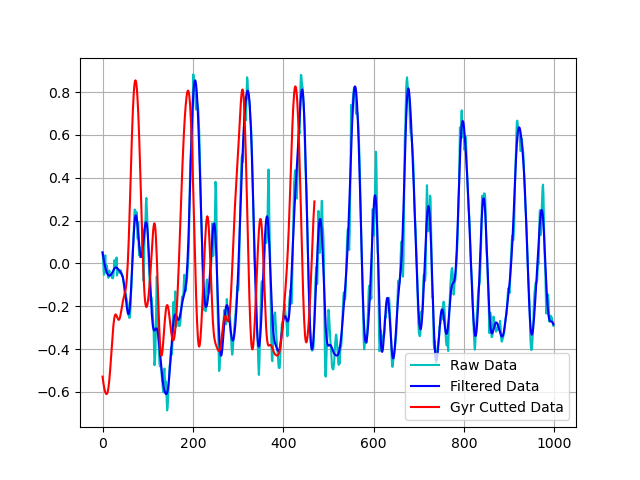

In [152]:
# pos = 'Normal', 'Upstairs', 'Downstairs'
pos = 'Normal'
# loc = 1, 3
loc = 3
# no = 0-7
no = 4
# axis = 0, 1, 2
axis = 0

plt.close()
plt.plot(eval(f'gyr{pos}_s{loc}')[no].iloc[:,(axis+1)], label='Raw Data', c = 'c')
plt.plot(eval(f'gyrFiltered{pos}_s{loc}')[no][:,axis], label='Filtered Data', c = 'b')
plt.plot(eval(f'gyrCut{pos}_s{loc}')[no][:,axis], label = 'Gyr Cutted Data', c = 'r')
# plt.plot(eval(f'gyrResample{pos}_s{loc}')[no][:,axis], label = 'Gyr Resampled Data', c = 'g')

plt.legend()
plt.show()

#### -- Test -- Save all cut data to plots

In [153]:
'''
for j in gaitpos:
    for i in smartphone:
        # variables of raw the data
        gyrl = eval(f'gyr{j}_s{i}')
        accl = eval(f'acc{j}_s{i}')
        # variables of filtered the data
        gyrF = eval(f'gyrFiltered{j}_s{i}')
        accF = eval(f'accFiltered{j}_s{i}')
        # variables of cutted the data
        gyrC = eval(f'gyrCut{j}_s{i}')
        accC = eval(f'accCut{j}_s{i}')

        for rg in range(0, len(gyrF)):
            plt.close()
            plt.plot(gyrl[rg].iloc[:,1], label='Raw Gyroscope Data', c = 'c')
            # plt.plot(accl[rg].iloc[:,1], label='Raw Accelerometer Data', c = 'm')

            plt.plot(gyrF[rg][:,0], label='Filtered Gyroscope Data', c = 'b')
            # plt.plot(accF[rg][:,0], label='Filtered Accelerometer Data', c = 'g')

            plt.plot(gyrC[rg][:,0], label='Gyroscope Cut Data', c = 'y')
            # plt.plot(accC[rg][:,0], label = 'Accelerometer Cut Data', c = 'r')

            plt.legend()
            plt.grid()
            plt.ioff()
            # plt.savefig(rootdir+f'/2 Accelerometer_Pictures/acc{j}_s{i}_{rg}.png')
            plt.savefig(rootdir+f'/1 Gyroscope_Pictures/gyr{j}_s{i}_{rg}.png')
'''

"\nfor j in gaitpos:\n    for i in smartphone:\n        # variables of raw the data\n        gyrl = eval(f'gyr{j}_s{i}')\n        accl = eval(f'acc{j}_s{i}')\n        # variables of filtered the data\n        gyrF = eval(f'gyrFiltered{j}_s{i}')\n        accF = eval(f'accFiltered{j}_s{i}')\n        # variables of cutted the data\n        gyrC = eval(f'gyrCut{j}_s{i}')\n        accC = eval(f'accCut{j}_s{i}')\n\n        for rg in range(0, len(gyrF)):\n            plt.close()\n            plt.plot(gyrl[rg].iloc[:,1], label='Raw Gyroscope Data', c = 'c')\n            # plt.plot(accl[rg].iloc[:,1], label='Raw Accelerometer Data', c = 'm')\n\n            plt.plot(gyrF[rg][:,0], label='Filtered Gyroscope Data', c = 'b')\n            # plt.plot(accF[rg][:,0], label='Filtered Accelerometer Data', c = 'g')\n\n            plt.plot(gyrC[rg][:,0], label='Gyroscope Cut Data', c = 'y')\n            # plt.plot(accC[rg][:,0], label = 'Accelerometer Cut Data', c = 'r')\n\n            plt.legend()\n      

In [204]:
gyrResampleNormal_s3[]


,X (rad/s),Y (rad/s),Z (rad/s)
0,0.157167,-0.113147,0.339072
1,-0.145546,-0.544033,0.106931
2,-0.019890,0.128940,-0.084526
3,-0.053116,0.012188,0.077767
4,-0.209465,0.149791,-0.038226
...,...,...,...
195,-1.352521,-0.893173,-0.382748
196,-1.593726,-1.041928,-0.614339
197,-0.351098,-0.957670,-0.327615
198,0.819053,-0.023116,-0.134120


### Resample data

#### Resample all the data

In [154]:
# Create arrays for resampled data
#gyrResampleNormal_s1 = []; gyrResampleUpstairs_s1 = []; gyrResampleDownstairs_s1 = []
gyrResampleNormal_s3 = []; gyrResampleUpstairs_s3 = []; gyrResampleDownstairs_s3 = []

#accResampleNormal_s1 = []; accResampleUpstairs_s1 = []; accResampleDownstairs_s1 = []
accResampleNormal_s3 = []; accResampleUpstairs_s3 = []; accResampleDownstairs_s3 = []

size = 200

for j in gaitpos:
    for i in smartphone:
            gyrl = eval(f'gyrCut{j}_s{i}')
            accl = eval(f'accCut{j}_s{i}')

            gyrrs = eval(f'gyrResample{j}_s{i}')
            accrs = eval(f'accResample{j}_s{i}')

            for rg in range(0, len(gyrl)):
                g = sp.resample(gyrl[rg], size, axis = 0)
                a = sp.resample(accl[rg], size, axis = 0)
                
                gyrrs.append(g)
                accrs.append(a)

#### Check if all the data is collected properly after resampling

In [155]:
# getting the data shape for reference
for j in gaitpos:
    for i in smartphone:
            gyr = eval(f'gyrResample{j}_s{i}')
            acc = eval(f'accResample{j}_s{i}')

            print(f'Shape of gyrResample{j}_s{i} is ------ {np.asarray((gyr), dtype = list).shape}')
            print(f'Shape of accResample{j}_s{i} is ------ {np.asarray((acc), dtype = list).shape} \n')

Shape of gyrResampleNormal_s3 is ------ (8, 200, 4)
Shape of accResampleNormal_s3 is ------ (8, 200, 4) 

Shape of gyrResampleUpstairs_s3 is ------ (8, 200, 4)
Shape of accResampleUpstairs_s3 is ------ (8, 200, 4) 

Shape of gyrResampleDownstairs_s3 is ------ (7, 200, 4)
Shape of accResampleDownstairs_s3 is ------ (7, 200, 4) 



#### Plot to compare the cut data, and resampled data

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
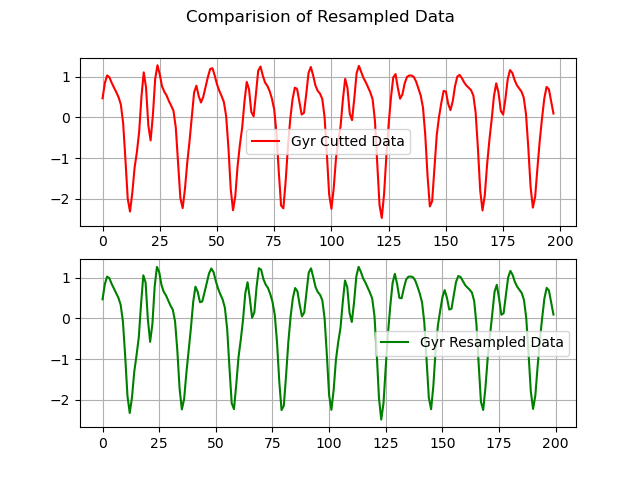

In [156]:
# pos = 'Normal', 'Upstairs', 'Downstairs'
pos = 'Normal'
# loc = 1, 3
loc = 3
# no = 0-7
no = 2
# axis = 0, 1, 2
axis = 0

plt.close()
fig, axs = plt.subplots(2,1)
fig.suptitle('Comparision of Resampled Data')

# axs[0].plot(eval(f'gyr{pos}_s{loc}')[no].iloc[:,(axis+1)], label='Raw Data', c = 'c')
# axs[0].plot(eval(f'gyrFiltered{pos}_s{loc}')[no][:,axis], label='Filtered Data', c = 'b')
axs[0].plot(eval(f'gyrCut{pos}_s{loc}')[no][:,axis], label = 'Gyr Cutted Data', c = 'r')
axs[0].x_lim = [0, 250]

axs[1].plot(eval(f'gyrResample{pos}_s{loc}')[no][:,axis], label = 'Gyr Resampled Data', c = 'g')

axs[0].legend()
axs[1].legend()
plt.show()

### Change the data type to pd.DataFrame and drop that extra frckin column

In [157]:

for j in gaitpos:
    for i in smartphone:
            gyrl = eval(f'gyrResample{j}_s{i}')
            accl = eval(f'accResample{j}_s{i}')

            for x in range(0, len(gyrl)):
                g = pd.DataFrame(data = gyrl[x], columns=['X (rad/s)', 'Y (rad/s)', 'Z (rad/s)', 'Unnamed'])
                a = pd.DataFrame(data = accl[x], columns=['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)', 'Unnamed'])
                
                g.drop(g.columns[3], axis=1, inplace=True)
                a.drop(a.columns[3], axis=1, inplace=True)

                gyrl[x] = g
                accl[x] = a


### Create subject specific dataframes

In [158]:
# defining arrays for subject specific data
#subNormal_s1 = []; subUpstairs_s1 = []; subDownstairs_s1 = []
subNormal_s3 = []; subUpstairs_s3 = []; subDownstairs_s3 = []

for j in gaitpos:
    for i in smartphone:
        gyr = eval(f'gyrResample{j}_s{i}')
        acc = eval(f'accResample{j}_s{i}')

        sub = eval(f'sub{j}_s{i}')

        for l in range(0, len(gyr)):
            # subject = pd.concat((gyr[l], acc[l]), axis = 1)
            
            ## to concatenate the data after the gyroscope data and convert it to pandas dataframe
            subject = np.concatenate((gyr[l], acc[l]), axis = 0)
            subject = pd.DataFrame(data = subject, columns=['X', 'Y', 'Z'])

            sub.append(subject)
sub[0]

,X,Y,Z
0,0.835265,-0.599597,1.225153
1,1.187492,-0.685714,1.642764
2,0.832777,-0.196561,0.813406
3,1.065330,-0.239404,0.691151
4,0.813815,-0.319127,0.486134
...,...,...,...
395,3.663414,-9.453709,-1.152444
396,3.443942,-8.848232,-0.816315
397,2.536238,-9.228604,-0.825620
398,2.794210,-8.842002,0.008083


### Normalize data

#### Normalize function

In [159]:
def normalize(datainput):
    norm=[]  
    #Filter the X, Y and Z axis of the input data
        # y=datainput[:,i]
    norm = preprocessing.normalize(datainput,axis=1)
    # resample[:,1] = sp.resample(dataInput[:,1],250)
    # resample[:,2] = sp.resample(dataInput[:,2],250)
    
    return norm

#### Normalize all the data

In [160]:
##Normalization, for loop needs to be present
# defining arrays for normal gyroscope data
gyrNormalizedNormal_s1 = []; gyrNormalizedUpstairs_s1 = []; gyrNormalizedDownstairs_s1 = []
gyrNormalizedNormal_s3 = []; gyrNormalizedUpstairs_s3 = []; gyrNormalizedDownstairs_s3 = []

# defining arrays for cut accelerometer data
accNormalizedNormal_s1 = []; accNormalizedUpstairs_s1 = []; accNormalizedDownstairs_s1 = []
accNormalizedNormal_s3 = []; accNormalizedUpstairs_s3 = []; accNormalizedDownstairs_s3 = []

# getting the data shape for reference
for j in gaitpos:
    for i in smartphone:
            #variables of cut data
            gyrCut = eval(f'gyrCut{j}_s{i}')
            accCut = eval(f'accCut{j}_s{i}')
            #variables of normalized data
            gyrN = eval(f'gyrNormalized{j}_s{i}')
            accN = eval(f'accNormalized{j}_s{i}')
             # getting the shape of the gyroscope and accelerometer data
            ng = len(gyrCut)
            na = len(accCut)

            # Filter all the data
            for rg in range(0, ng):
                gN = normalize(gyrCut[rg])
                gyrN.append(gN)

            for ra in range(0, na):
                
                aN = normalize(accCut[ra])
                accN.append(aN)


#### Check if the data is collected properly after normalization

In [161]:
# getting the normalized data shape for reference
for j in gaitpos:
    for i in smartphone:
            gyr = eval(f'gyrNormalized{j}_s{i}')
            acc = eval(f'accNormalized{j}_s{i}')

            print(f'Shape of gyrNormalized{j}_s{i} is ------ {np.asarray((gyr), dtype = list).shape}')
            print(f'Shape of accNormalized{j}_s{i} is ------ {np.asarray((acc), dtype = list).shape} \n')


Shape of gyrNormalizedNormal_s3 is ------ (8,)
Shape of accNormalizedNormal_s3 is ------ (8,) 

Shape of gyrNormalizedUpstairs_s3 is ------ (8,)
Shape of accNormalizedUpstairs_s3 is ------ (8,) 

Shape of gyrNormalizedDownstairs_s3 is ------ (7,)
Shape of accNormalizedDownstairs_s3 is ------ (7,) 



### Plotttt function

In [162]:
def gyrPlot(x, y, lbl, xlbl='None', ylbl='None', ttl='None', clr='None'):
    plt.close()
    plt.plot(x, y, label=lbl, c=clr)

    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.title(ttl)

    plt.legend()
    plt.grid()
    plt.show()

## PCA

<class 'pandas.core.frame.DataFrame'>


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
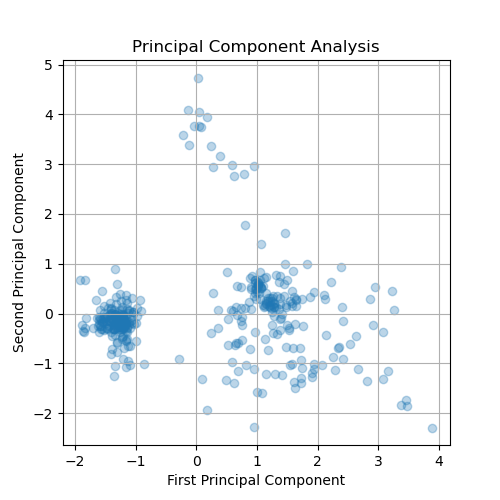

In [205]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X=sub[0][['X','Y','Z']]
#Y=['label']
print(type(X))
X_normalized=(X-X.mean())/X.std()
scaler = StandardScaler()
scaler.fit(X_normalized)
scaled_data = scaler.transform(X_normalized)
pca=PCA(n_components=2)
X_pca= pca.fit_transform(scaled_data)
scaled_data.shape
X_pca.shape
plt.close()
plt.figure(figsize=(5,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c =None, cmap = 'viridis', alpha = 0.3)
plt.title('Principal Component Analysis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.show()

plt.savefig('PCA.png')

## ---> AI Model